# Module 3a: Dimension Reduction using Feature Selection
Charles Pang, PSUPR Semester 1 2021 <br><br>
**1. Filter Method:** a.Correlation, b.Anova <br>
**2. Wrapper Method:** c.Forward Feature Selection, d.Backward Feature Elimination, e.Recursive Feature Elimination <br>
**3. Embedded Methods:** f.Random Forest Classifier <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load the dataset
data = pd.read_csv('Cancer.csv')
data = data.drop(columns=['id','Unnamed: 32'], axis=1)

print(data.shape)
print(data.isnull().values.any()) # check for any missing values
data.diagnosis.value_counts() # show the distribution of M/B

(569, 31)
False


B    357
M    212
Name: diagnosis, dtype: int64

In [3]:
from sklearn.model_selection import train_test_split

target = 'diagnosis'
X = data.loc[:, data.columns != target]
Y = data.loc[:, data.columns == target]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=52)
features = pd.DataFrame(list(X_train.columns.values))

In [4]:
# Establish a baseline for comparison using LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=0.01)
lr = logreg.fit(X_train, y_train)
print("LogReg Training set score:",lr.score(X_train, y_train))
print("       Test set score    :",lr.score(X_test, y_test))

LogReg Training set score: 0.9221105527638191
       Test set score    : 0.9473684210526315


# 1. Filter Methods

## (a) Correlation Analysis

' correlation >= 0.9\n1)radius_mean: perimeter_mean, area_mean, radius_worst, perimeter_worst, area_worst \n2)texture_mean: texture_worst, Compactness_worst\n3)Compactness_mean: concavity_mean\n4)concave points_mean: concave points_worst\n5)radius_se: perimeter_se, area_se\n6)concavity_se: Compactness_se, concave points_se \n'

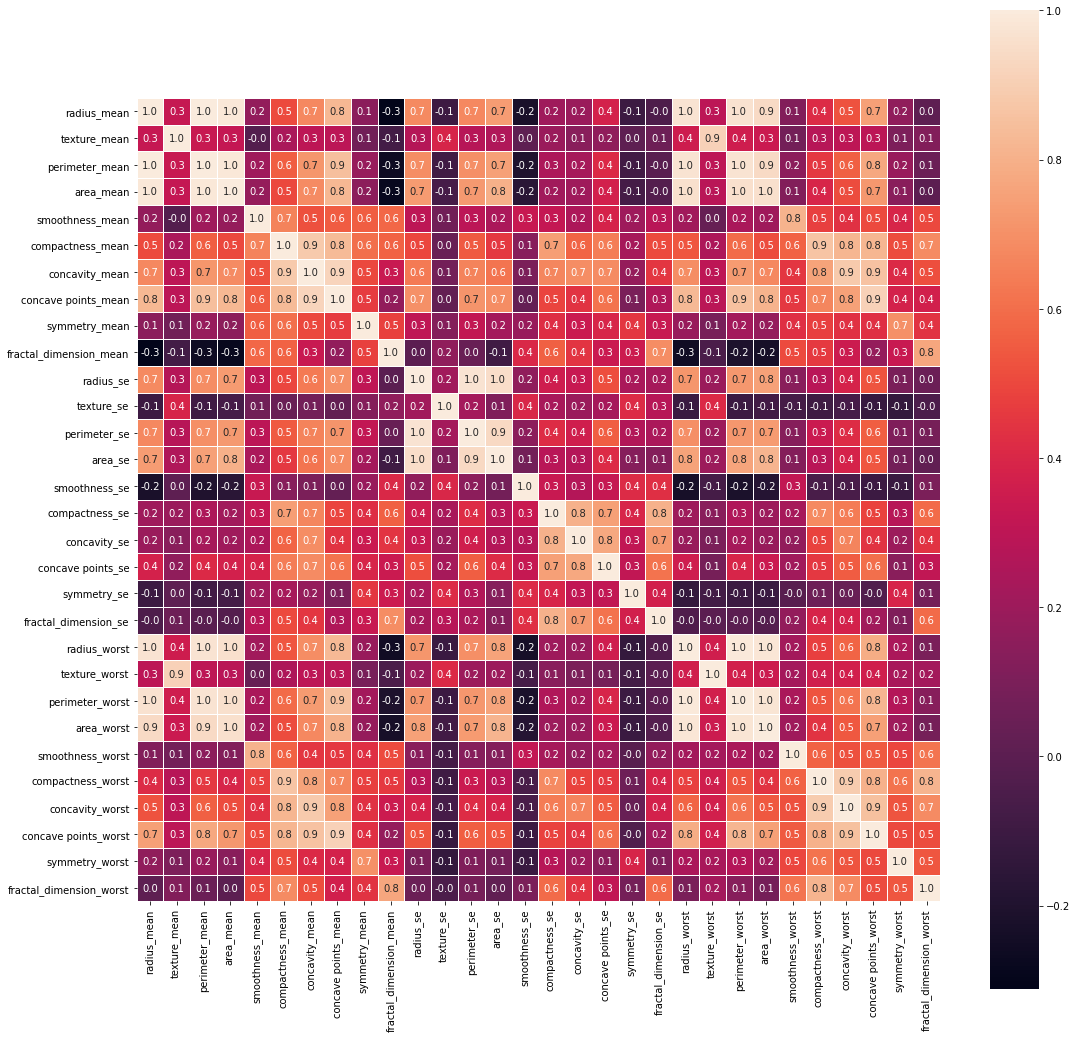

In [5]:
f = plt.figure(figsize=(18, 18))
ax = plt.subplot(aspect='equal')
corplot = sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

''' correlation >= 0.9
1)radius_mean: perimeter_mean, area_mean, radius_worst, perimeter_worst, area_worst 
2)texture_mean: texture_worst, Compactness_worst
3)Compactness_mean: concavity_mean
4)concave points_mean: concave points_worst
5)radius_se: perimeter_se, area_se
6)concavity_se: Compactness_se, concave points_se 
'''

In [6]:
# Remove Corelated Features 
deselect = ['perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
            'texture_worst', 'compactness_worst','concavity_mean', 'concave points_worst',
            'perimeter_se', 'area_se', 'compactness_se', 'concave points_se']

In [8]:
# test the reduced features
X_train_new = X_train.drop(deselect,axis = 1)
X_test_new = X_test.drop(deselect,axis = 1) 
print(X_train_new.shape)

lr = logreg.fit(X_train_new, y_train)
print("Corr Training set score:",lr.score(X_train_new, y_train))
print("     Test set score    :",lr.score(X_test_new, y_test))

(398, 17)
Corr Training set score: 0.8919597989949749
     Test set score    : 0.9005847953216374


## (b) Anova (f_classif)

In [9]:
from sklearn.feature_selection import f_classif
f=17 # TRY f=15 or less

Anova = SelectKBest(score_func=f_classif, k=f).fit(X_train, y_train)
AnovaRanking = pd.DataFrame({'Feature':list(X_train.columns),'Scores':Anova.scores_})
AnovaRanking.sort_values(by='Scores', ascending=False, inplace=True)

print('Top', f, 'selected:')
AnovaRanking.head(17)

Top 17 selected:


,Feature,Scores
27,concave points_worst,676.716398
7,concave points_mean,630.854979
22,perimeter_worst,595.995645
20,radius_worst,559.930079
2,perimeter_mean,462.976937
23,area_worst,458.134934
0,radius_mean,419.834601
3,area_mean,409.643914
6,concavity_mean,407.978442
26,concavity_worst,302.023031


In [10]:
X_train_new = Anova.transform(X_train) 
X_test_new = Anova.transform(X_test)

lr = logreg.fit(X_train_new, y_train)
print("Anova Training set score:",lr.score(X_train_new, y_train))
print("      Test set score    :",lr.score(X_test_new, y_test))

Anova Training set score: 0.9221105527638191
      Test set score    : 0.9473684210526315


# 2. Wrapper Methods

In [11]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.svm import SVC, LinearSVC
# I am using the Support Vector Classifier (SVC) algoritm (categorical output). 
# Others are OLS, Linear/Log Regression, Decision Trees, etc.

## (c) Forward Feature Selection (FFS)

In [12]:
# note that you could perform a Hyperparameter estimation for C

model = LinearSVC(C=0.5) # higher values tend to overfit
model.fit(X_train, y_train)

sfs = SFS(estimator=model, n_features_to_select=f, direction='forward').fit(X_train, y_train)
print('FFS:'f'{features[sfs.get_support()]}')

FFS:                         0
4          smoothness_mean
5         compactness_mean
8            symmetry_mean
9   fractal_dimension_mean
11              texture_se
13                 area_se
14           smoothness_se
15          compactness_se
16            concavity_se
17       concave points_se
18             symmetry_se
20            radius_worst
21           texture_worst
24        smoothness_worst
26         concavity_worst
27    concave points_worst
28          symmetry_worst


In [13]:
#sfs.transform(X): Reduce X to the selected features.
X_train_new = sfs.transform(X_train)
X_test_new = sfs.transform(X_test)

# test the SFS reduced dataset with Baseline Model (logreg)
lr = logreg.fit(X_train_new, y_train)
print('SFS: Base Model Training:', lr.score(X_train_new, y_train))
print('                    Test:', lr.score(X_test_new, y_test))
print('\nIs the result better than the baseline Logreg with all 31 features?\n')

# Use SFS reduced dataset with same estimator (SVC Forward)
# note that we cannot set random state - so every run will be different
sfs_test = model.fit(X_train_new, y_train)
print('Model Training:',sfs_test.score(X_train_new, y_train))
print('      Test    :',sfs_test.score(X_test_new, y_test))

SFS: Base Model Training: 0.9246231155778895
                    Test: 0.9298245614035088

Is the result better than the baseline Logreg with all 31 features?

Model Training: 0.9597989949748744
      Test    : 0.9649122807017544


## (d) Backward Feature Elimination (BFE)

In [14]:
sfs = SFS(model, n_features_to_select=f, direction='backward').fit(X_train, y_train)
print('BFE:'f'{features[sfs.get_support()]}')

BFE:                          0
2            perimeter_mean
3                 area_mean
7       concave points_mean
9    fractal_dimension_mean
11               texture_se
14            smoothness_se
16             concavity_se
17        concave points_se
18              symmetry_se
19     fractal_dimension_se
20             radius_worst
21            texture_worst
23               area_worst
24         smoothness_worst
26          concavity_worst
27     concave points_worst
29  fractal_dimension_worst


In [18]:
X_train_new = sfs.transform(X_train)
X_test_new = sfs.transform(X_test)

# test the SFS reduced dataset with Baseline Model (logreg)
lr = logreg.fit(X_train_new, y_train)
print('BFE: Base Model Training:',lr.score(X_train_new, y_train))
print('                Test    :',lr.score(X_test_new, y_test))
print('\nIs the result better than the baseline Logreg with all 31 features?')
print('Is the result better than the SVC Forward?\n')

# Use SFS reduced dataset with same estimator (SVC backward)
sfs_test = model.fit(X_train_new, y_train)
print('Model Training:',sfs_test.score(X_train_new, y_train))
print('      Test    :',sfs_test.score(X_test_new, y_test))

BFE: Base Model Training: 0.9396984924623115
                Test    : 0.9649122807017544

Is the result better than the baseline Logreg with all 31 features?
Is the result better than the SVC Forward?

Model Training: 0.914572864321608
      Test    : 0.9473684210526315


## (e) Recursive Feature Elimination- RFE

In [19]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=model, n_features_to_select=f, step=1).fit(X_train, y_train)

RFEfeatures = pd.DataFrame({'Feature':list(X_train.columns),'Scores':rfe.ranking_})
RFEfeatures.sort_values(by='Scores', ascending=True, inplace=True)
RFEfeatures.head(17)

,Feature,Scores
0,radius_mean,1
22,perimeter_worst,1
28,symmetry_worst,1
13,area_se,1
12,perimeter_se,1
11,texture_se,1
21,texture_worst,1
25,compactness_worst,1
23,area_worst,1
6,concavity_mean,1


In [20]:
# test the reduced dataset 
X_train_new = rfe.transform(X_train)
X_test_new = rfe.transform(X_test)

# test the SBFE reduced dataset with Baseline Model
lr = logreg.fit(X_train_new, y_train)
print('RFE: Base Model Training:',lr.score(X_train_new, y_train))
print('                Test    :',lr.score(X_test_new, y_test))

# Use BFE dataset with same estimator, less likely to overfit vs FFS
sfs_test = model.fit(X_train_new, y_train)
print('Model Training:',sfs_test.score(X_train_new, y_train))
print('      Test    :',sfs_test.score(X_test_new, y_test))

RFE: Base Model Training: 0.9346733668341709
                Test    : 0.9473684210526315
Model Training: 0.9221105527638191
      Test    : 0.9590643274853801


# 3. Embedded Methods

## (f) Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score

#n_estimators = number of trees to build
rfc = RandomForestClassifier(n_estimators=500, random_state=43)      
rfc = rfc.fit(X_train,y_train)

accuracy = accuracy_score(y_test, rfc.predict(X_test))
print('RandomForest : ', accuracy)

final_df = pd.DataFrame({"Features": X_train.columns, "Importances":rfc.feature_importances_})
# Sklearn: "computed as the mean and standard deviation of accumulation of the impurity decrease within each tree."
final_df.set_index('Importances')
final_df.sort_values('Importances',ascending = False, inplace=True)
# final_df['Importances'].sum()
final_df.head(17)

RandomForest :  0.9766081871345029


,Features,Importances
27,concave points_worst,0.144156
22,perimeter_worst,0.129047
23,area_worst,0.108481
7,concave points_mean,0.100994
20,radius_worst,0.092711
6,concavity_mean,0.058696
2,perimeter_mean,0.048802
3,area_mean,0.048656
26,concavity_worst,0.038658
0,radius_mean,0.034895


In [47]:
from sklearn.feature_selection import SelectFromModel
selrfc = SelectFromModel(RandomForestClassifier(n_estimators = 500, random_state=43))
selrfc.fit(X_train, y_train)
selrfc.get_support()

selected_feat = X_train.columns[(selrfc.get_support())]
print(len(selected_feat))
print(selected_feat)

10
Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst',
       'concavity_worst', 'concave points_worst'],
      dtype='object')


In [48]:
# test the reduced dataset 
X_train_new = selrfc.transform(X_train)
X_test_new = selrfc.transform(X_test)

rfc = RandomForestClassifier(n_estimators=500, random_state=43)      
rfc = rfc.fit(X_train_new,y_train)
accuracy = accuracy_score(y_test, rfc.predict(X_test_new))
print('RandomForest : ', accuracy)

RandomForest :  0.9766081871345029


In [50]:
# use the RandomForest Important Features on Baseline model
lr = logreg.fit(X_train_new, y_train)
print('SFS: Base Model Training:', lr.score(X_train_new, y_train))
print('                    Test:', lr.score(X_test_new, y_test))
print('\nIs the result better than the baseline Logreg with all 31 features?\n')

SFS: Base Model Training: 0.9271356783919598
                    Test: 0.9707602339181286

Is the result better than the baseline Logreg with all 31 features?

